# Part-A
The solution cosists of the Classifier class, plus a few hardcoded functions for the log-likelihood/derivative, specifically:


In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt


def p_x_given_theta(x: npt.ArrayLike, theta: float) -> np.ndarray:
    """The probability density function p(x|theta).

    Args:
        x (numpy.typing.ArrayLike): The value(s) at which to evaluate the density function.
        theta (float): The theta parameter of the distribution.

    Returns:
        numpy.ndarray: The value of the density function at x.
    """
    x = np.asarray(x)
    return (1. / np.pi) * (1. / (1. + (x - theta)**2))


def log_likelihood(data: npt.ArrayLike, theta: float) -> float:
    """The log-likelihood function log(p(D|theta) = sum(log(p(xi|theta), for xi in data)
    for the PDF given in the instructions.

    Args:
        theta (float): The theta parameter of the distribution.
        data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.

    Returns:
        float: The log-likelihood of the data given the theta parameter.
    """
    data = np.asarray(data)
    return np.sum(np.log(p_x_given_theta(data, theta)))


def log_likelihood_derivative(theta: float, data: npt.ArrayLike) -> float:
    """The derivative of the log-likelihood function for the PDF given in the instructions.

    Args:
        theta (float): The theta parameter of the distribution.
        data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
    
    Returns:
        float: The derivative of the log-likelihood of the data given the theta parameter.
    """
    return np.sum([2 * (data - theta) / (1 + (data - theta)**2)])


def plot_log_likelihood(d1: npt.ArrayLike, d2: npt.ArrayLike, theta: npt.ArrayLike) -> None:
    """Plot the log-likelihood functions for the two datasets.

    Args:
        d1 (numpy.typing.ArrayLike): The first dataset.
        d2 (numpy.typing.ArrayLike): The second dataset.
        theta (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
    """
    # Compute the log-likelihood for each value of theta
    log_likelihoods_1 = [log_likelihood(d1, t) for t in theta]
    log_likelihoods_2 = [log_likelihood(d2, t) for t in theta]

    # Plot the log-likelihood functions
    plt.figure()
    plt.plot(theta, log_likelihoods_1, label="D1")
    plt.plot(theta, log_likelihoods_2, label="D2")
    plt.xlabel("Theta")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.show()


def plot_log_likelihood_derivative(d1: npt.ArrayLike, d2: npt.ArrayLike, theta: npt.ArrayLike) -> None:
    """Plot the derivative of the log-likelihood functions for the two datasets.

    Args:
        d1 (numpy.typing.ArrayLike): The first dataset.
        d2 (numpy.typing.ArrayLike): The second dataset.
        theta (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
    """
    # Plot the log-likelihood derivative
    plt.figure()
    plt.plot(theta, [log_likelihood_derivative(t, d1) for t in theta], label="D1")
    plt.plot(theta, [log_likelihood_derivative(t, d2) for t in theta], label="D2")
    plt.xlabel("Theta")
    plt.ylabel("Log-likelihood derivative")
    plt.legend()
    plt.show()


class Classifier:
    """The classifier for the PDF given in the instructions.

    The classifier is tailored to work only with the PDF given in the instructions.

    functions:
        fit: Fit the classifier to the two datasets.
    
    Example:
        d1 = np.random.uniform(-10, 10, 100)
        d2 = np.random.uniform(-10, 10, 100)
        # Fit the classifier to the datasets
        classifier = Classifier()
        theta_1, theta_2 = classifier.fit(d1, d2)
    """

    def __init__(self):
        pass

    def fit(
        self,
        d_1: npt.ArrayLike,
        d_2: npt.ArrayLike,
        solve_method: str = 'evaluating',
        thetas: npt.ArrayLike = None
    ) -> Tuple[float, float]:
        """Fit the classifier to the two datasets.

        The classifier is fitted by finding the optimal theta parameter for each dataset.

        Args:
            d_1 (numpy.typing.ArrayLike): The first dataset.
            d_2 (numpy.typing.ArrayLike): The second dataset.
            solve_method (str, optional): The method to use for solving the log-likelihood derivative equation.
                Can be "numeric", "symbolic" or "evaluating". Defaults to "numeric".
                - "numeric": Uses the scipy.optimize.root function to find the root of the derivative.
                - "symbolic": Solves the derivative equation symbolically.
                - "evaluating": Evaluates the log-likelihood function for all thetas given.
            thetas (numpy.typing.ArrayLike, optional): The values of theta to evaluate the log-likelihood functions on.
                Used only if the solve_method is "evaluating". Defaults to None.

        Returns:
            Tuple[float, float]: The optimal theta parameters for the two datasets.
        """
        if solve_method == 'numeric':
            # The optimal thetas are found by solving the derivative of the log-likelihood function.
            # The starting points are chosen by examining the derivative plot first.
            # The symbolic solution is also available, that finds all the roots without needing a starting point,
            # but it is slow.
            theta_1 = self._solve_by_numeric_method(d_1, starting_point=2.5) # Starting point is set to 2.5 after examining the derivative plot
            theta_2 = self._solve_by_numeric_method(d_2, starting_point=-2.5) # Starting point is set to -2.5 after examining the derivative plot
        elif solve_method == 'symbolic':
            theta_1 = self._solve_by_symbolic_method(d_1)
            theta_2 = self._solve_by_symbolic_method(d_2)
        elif solve_method == 'evaluating':
            theta_1 = self._solve_by_evaluating_thetas(d_1, thetas)
            theta_2 = self._solve_by_evaluating_thetas(d_2, thetas)
        else:
            raise ValueError("Invalid solve method. Use 'numeric', 'symbolic' or 'evaluating'.")
        
        return theta_1, theta_2
    
    def predict(
        self,
        data: npt.ArrayLike,
        theta_1: float,
        theta_2: float,
        prior_1: float,
        prior_2:float
    ) -> npt.ArrayLike:
        """Predict the class of the data.

        The class is predicted by choosing the class with the highest log-likelihood.

        Args:
            data (numpy.typing.ArrayLike): The data to predict the class of.
            theta_1 (float): The optimal theta parameter for the first dataset.
            theta_2 (float): The optimal theta parameter for the second dataset.

        Returns:
            numpy.typing.ArrayLike: The class of the data
        """
        def g(x: npt.ArrayLike) -> npt.ArrayLike:
            return (
                np.log(p_x_given_theta(x, theta_1))
                - np.log(p_x_given_theta(x, theta_2))
                + prior_1
                - prior_2
            )
        
        return g(data)

    @staticmethod
    def _solve_by_symbolic_method(data: npt.ArrayLike) -> float:
        """Solve the log-likelihood derivative equation symbolically.

        Finds all the real roots of the derivative of the log-likelihood function.
        Pretty slow.
        
        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        from sympy import Eq, S, solve, symbols # Inefective, but we want these to be optional dependencies
                                                # And we expect the function to run one time only

        # Define the symbolic variables and function
        theta = symbols('theta')

        f_prime = sum(2 * (x - theta) / (1 + (x - theta)**2) for x in data)

        # Solve symbolically
        try:
            roots = solve(Eq(f_prime, 0), theta, domain=S.Reals)
        except Exception as e:
            print(f"Root finding failed. {format(e)}")
            return None
        
        # Find the optimal theta
        log_likelihoods = {}
        for r in roots:
            if r.is_real:
                try:
                    log_likelihoods[r] = log_likelihood(data, float(r))
                except Exception as e:
                    print(f"Log-likelihood evaluation failed. {format(e)}")
                    continue
     
        optimal_theta = max(log_likelihoods.keys(), key=lambda r: log_likelihoods[r])
        return optimal_theta

    @staticmethod
    def _solve_by_numeric_method(data: npt.ArrayLike, starting_point: float = 0) -> float:
        """Solve the log-likelihood derivative equation numerically.

        Finds the optimal theta parameter by solving the derivative of the log-likelihood function.
        Uses the scipy.optimize.root function to find the root of the derivative. The scipy.optimize.root
        function stops once the first root is found, so a good starting point is needed to find the correct
        root, that is the global maximum of the log-likelihood function.

        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
            starting_point (float, optional): The starting point for the optimization. Defaults to 0.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        from scipy.optimize import root # Inefective, but we want these to be optional dependencies
                                         # And we expect the function to run one time only

        solution = root(log_likelihood_derivative, starting_point, args=(data,))
        if solution.success:
            theta = solution.x[0]
            return theta
        else:
            print("Optimization failed.")
            return None
    
    @staticmethod
    def _solve_by_evaluating_thetas(data: npt.ArrayLike, thetas: npt.ArrayLike) -> float:
        """Solve the log-likelihood derivative equation by evaluating all thetas.

        Finds the optimal theta parameter by evaluating the log-likelihood function for all thetas.

        Args:
            data (numpy.typing.ArrayLike): The data to evaluate the likelihood function on.
            thetas (numpy.typing.ArrayLike): The values of theta to evaluate the log-likelihood functions on.
        
        Returns:
            float: The optimal theta parameter that maximizes the log-likelihood function.
        """
        log_likelihoods = [log_likelihood(t, data) for t in thetas]
        optimal_theta = thetas[np.argmax(log_likelihoods)]
        return optimal_theta


### Solution for 1st query
Must be run and examined with the first code cell.

Theta for d_1 using the `evaluating` approach: 2.5925925925925917
Theta for d_2 using the `evaluating` approach: -3.153153153153153
Theta for d_1 using the `numeric` approach: 2.599795610944729
Theta for d_2 using the `numeric` approach: -3.158576677026769
Theta for d_1 using the `symbolic` approach: 2.59979561094459
Theta for d_2 using the `symbolic` approach: -3.15857667702677


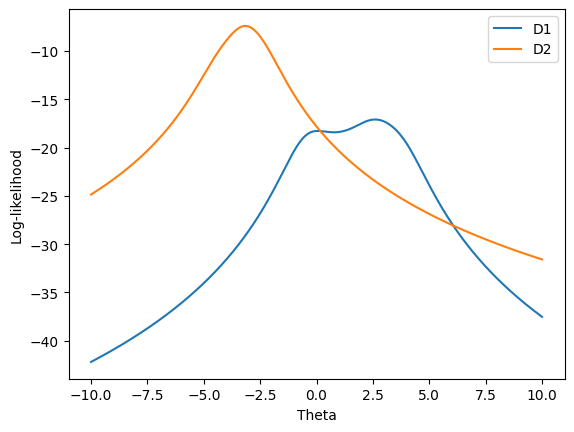

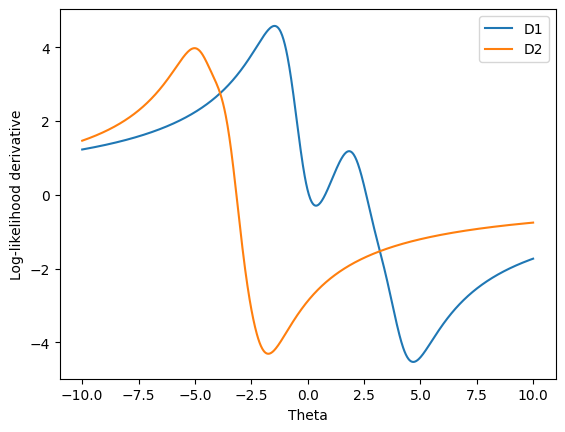

In [3]:
import numpy as np


d_1 = [2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1]
d_2 = [-4.5, -3.4, -3.1, -3.0, -2.3]

theta = np.linspace(-10, 10, 1000)

# Fit the classifier to the datasets
classifier = Classifier()
theta_1, theta_2 = classifier.fit(d_1, d_2, solve_method='evaluating', thetas=theta)
print(f"Theta for d_1 using the `evaluating` approach: {theta_1}")
print(f"Theta for d_2 using the `evaluating` approach: {theta_2}")
# Comment out the following lines if you don't want to see all the methods
theta_1, theta_2 = classifier.fit(d_1, d_2, solve_method='numeric')
print(f"Theta for d_1 using the `numeric` approach: {theta_1}")
print(f"Theta for d_2 using the `numeric` approach: {theta_2}")
# This is really slow, so we comment it out
# theta_1, theta_2 = classifier.fit(d_1, d_2, solve_method='symbolic')
# print(f"Theta for d_1 using the `symbolic` approach: {theta_1}")
# print(f"Theta for d_2 using the `symbolic` approach: {theta_2}")

# Plots
plot_log_likelihood(d_1, d_2, theta)
# Plot the derivative of the log-likelihood functions, 
# so we can chse a good starting point for solving the derivative.
plot_log_likelihood_derivative(d_1, d_2, theta)

# **Approach Overview**

The provided code implements a classifier tailored to fit two datasets by maximizing the log-likelihood function of a specific probability density function (PDF). Below is a summary of the approach:

## **1. Hardcoding the Derivative**
- The log-likelihood function for the PDF is manually derived, and its derivative is implemented in the `log_likelihood_derivative` function.
- The PDF is:
  $$
  p(x|\theta) = \frac{1}{\pi \left(1 + (x - \theta)^2 \right)}
  $$
- The log-likelihood for a dataset $D = {x_1, x_2, \dots, x_n}$ is:
  $$
  \log L(\theta) = \sum_{i=1}^n \log \left( \frac{1}{\pi \left(1 + (x_i - \theta)^2 \right)} \right)
  $$
  Simplified:
  $$
  \log L(\theta) = -n \log(\pi) - \sum_{i=1}^n \log \left(1 + (x_i - \theta)^2 \right)
  $$
- The derivative of the log-likelihood with respect to $\theta$ is:
  $$
  \frac{\partial \log L}{\partial \theta} = \sum_{i=1}^n \frac{2(x_i - \theta)}{1 + (x_i - \theta)^2}
  $$
- This derivative was hardcoded in the function `log_likelihood_derivative` and used to solve for the optimal $\theta$.

## **2. Multiple Methods for Fitting**
Three different methods are implemented in the `fit` function to find the optimal \(\theta\):

### **a. Numerical Solution (Default)**
- Uses `scipy.optimize.root` to numerically solve:
  $$
  \frac{\partial \log L}{\partial \theta} = 0
  $$
- Relies on a good starting point (e.g., $2.5$ for $d_1$, $-2.5$ for $d_2$) to guide the solver.
- The starting points were chosen by analyzing the graph of the log-likelihood derivative, focusing on where the derivative crosses zero while transitioning from negative to positive values. This ensures the critical point corresponds to a maximum rather than a minimum. Since the solver stops at the first critical point it encounters, selecting an appropriate starting point is crucial for accurate results.
- Efficient and practical for most datasets.

### **b. Symbolic Solution**
- Leverages SymPy to solve the derivative equation symbolically:
  $$
  \frac{\partial \log L}{\partial \theta} = 0
  $$
- Filters real roots and evaluates the log-likelihood at each root to identify the global maximum.
- More rigorous but slower and computationally expensive.

### **c. Evaluation over a Range**
- Evaluates the log-likelihood function:
  $$
  \log L(\theta)
  $$
  across a grid of $\theta$ values and selects the value that maximizes it.
- Does not require `scipy` or `sympy`, making it lightweight and straightforward, but it can be computationally expensive for fine-grained searches.

## **3. Classifier Implementation**
- The `Classifier` class encapsulates the fitting and prediction logic:
  - **Fitting**: Finds optimal $\theta$ for each dataset $d_1$ and $d_2$ using the chosen method.
  - **Prediction**: Classifies new data based on the fitted parameters and prior probabilities.

## **4. Requirements**
Below is a list of required Python libraries and their purpose:
- `numpy`: For numerical computation, arrays, and mathematical operations.
- `matplotlib`: For plotting the log-likelihood and its derivative.
- `scipy` (optional): Required for the numerical fitting method (`scipy.optimize.root`).
- `sympy` (optional): Required for the symbolic fitting method (`sympy.solve`).

### **Minimal Setup**
If you only use the **evaluation-based fitting method**, you only need:
- `numpy`

### **Full Setup**
If you want to use all fitting methods (numerical, symbolic, and evaluation), install:
```bash
pip install numpy matplotlib scipy sympy
```

# **Results**

### **Optimal Thetas Found**
- **theta_1 = 2.5998**: Maximizes the log-likelihood for dataset $d_1$.
- **theta_2 = -3.1586**: Maximizes the log-likelihood for dataset $d_2$.

### **Plots Interpretation**
1. **Log-Likelihood Functions**:
   - The log-likelihood curves for $d_1$ and $d_2$ exhibit peaks corresponding to their respective optimal $\theta$ values $2.5998$ for $d_1$ and $-3.1586$ for $d_2$.
   - These peaks clearly indicate the parameter values that maximize the likelihood of the datasets.

2. **Log-Likelihood Derivatives**:
   - The derivative plots reveal where the derivative crosses zero, marking the critical points.
   - For $d_1$, the derivative crosses zero passing from negative to positive values near $2.6$, and for $d_2$, near $-3$. These values align with the computed optimal $\theta$ values.
   - The starting points for the solver were chosen by examining these graphs, focusing on crossings where the derivative transitions from negative to positive values. This ensures that the critical points correspond to maxima rather than minima.

### **Conclusion**
- The results demonstrate that the implementation accurately identifies the maximum likelihood estimates (MLEs) for the datasets, leveraging numerical, symbolic, and evaluation-based methods.
- The symbolic method is valid for this specific probability density function (PDF) since it is analytically differentiable. However, symbolic solving may fail for other PDFs that are more complex or lack closed-form derivatives.
- Because the PDF is known, we compute its derivative manually for efficiency. If the PDF were unknown or complex, we could instead compute the derivative numerically or entirely bypass the need for a derivative by using the evaluation-based approach, where the log-likelihood is directly maximized over a grid of parameter values.
- This highlights the flexibility of the implementation: it can adapt to situations where the derivative cannot be explicitly computed or symbolically solved.
- Overall, the combination of these approaches provides a robust framework for fitting the model to data and finding optimal parameters.



# Solution for 2nd query
Depend also on the first code cell.

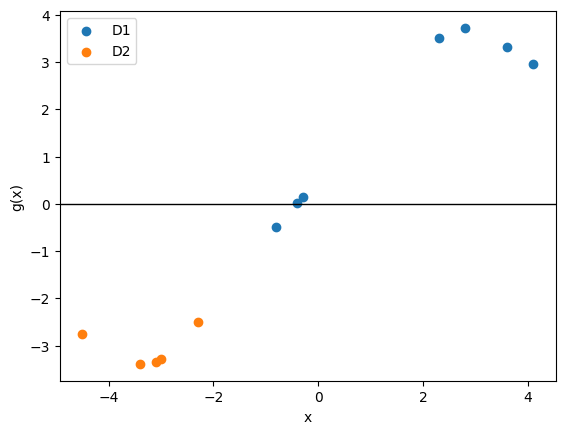

In [49]:
import matplotlib.pyplot as plt


d_1 = [2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1]
d_2 = [-4.5, -3.4, -3.1, -3.0, -2.3]

# Maximum likelihood thetas taken from the first part
theta_1 = 2.599795610944729
theta_2 = -3.158576677026769

# Compute the priors proportionally to the number of samples in each dataset
prior_1 = len(d_1) / (len(d_1) + len(d_2))
prior_2 = len(d_2) / (len(d_1) + len(d_2))

classifier = Classifier()

g_values_d_1 = classifier.predict(d_1, theta_1, theta_2, prior_1, prior_2)
g_values_d_2 = classifier.predict(d_2, theta_1, theta_2, prior_1, prior_2)
predicted_classes_d_1 = np.where(g_values_d_1 >= 0, 1, 2)
predicted_classes_d_2 = np.where(g_values_d_2 >= 0, 1, 2)

# Plot the g values
plt.figure()
plt.scatter(d_1, g_values_d_1, label="D1")
plt.scatter(d_2, g_values_d_2, label="D2")
plt.axhline(0, color='black', lw=1)
plt.xlabel("x")
plt.ylabel("g(x)")
plt.legend()
plt.show()


# **Results**

### **Classifier Predictions**

The classifier is used to predict the class labels for the datasets $d_1$ and $d_2$, based on the maximum likelihood parameters $\theta_1$ and $\theta_2$, and prior probabilities derived from the dataset sizes.

1. **Dataset Priors:**
   - The priors are computed as:
     $$
     p(\omega_1) = \frac{|d_1|}{|d_1| + |d_2|}, \quad p(\omega_2) = \frac{|d_2|}{|d_1| + |d_2|}
     $$
   - These reflect the relative sizes of the datasets and ensure the model accounts for any imbalance.

2. **Prediction Function g(x):**
   - The prediction for a given point $x$ is determined by the function $g(x)$:
     $$
     g(x) = \log p(x|\theta_1) - \log p(x|\theta_2) + \log(p(\omega_1)) - \log(p(\omega_2))
     $$
   - **Interpretation**: $g(x)$ determines whether the likelihood of $x$ belonging to class 1 $p(\omega_1|x)$ is greater than the likelihood of  $x$ belonging to class 2 $p(\omega_2|x)$. Specifically:
     - If \(g(x) > 0\), then:
       $$
       \log(p(x|\theta_1)) + \log(p(\omega_1)) > \log(p(x|\theta_2)) + \log(p(\omega_2))
       $$
       $$
       \implies \log(p(x|\theta_1)p(\omega_1)) > \log(p(x|\theta_2)p(\omega_2))
       $$
       $$
       \implies p(x|\theta_1)p(\omega_1) / p(x) > p(x|\theta_2)p(\omega_2) / p(x)
       $$
       $$
       \implies p(\omega_1|x) > p(\omega_2|x)
       $$
       Hence, $x$ is classified as belonging to class 1.
     - If $g(x) < 0$, then:
       $$
       p(\omega_1|x) < p(\omega_2|x)
       $$
       Hence, $x$ is classified as belonging to class 2.

3. **Class Predictions:**
   - Using the computed $g(x)$ values, the class for each data point in $d_1$ and $d_2$ is assigned:
     $$
     \text{Class} = 
     \begin{cases} 
     1 & \text{if } g(x) \geq 0 \\ 
     2 & \text{if } g(x) < 0 
     \end{cases}
     $$

### **Plotting g(x) Values**
- A scatter plot shows the $g(x)$ values for each data point in $d_1$ and $d_2$.
- The $x-axis$ corresponds to the data points, and the $y-axis$ represents their $g(x)$ values.
- The horizontal line $g(x) = 0$ indicates the decision boundary:
  - Points above the line $g(x) \geq 0$ are classified as belonging to $d_1$.
  - Points below the line $g(x) < 0$ are classified as belonging to $d_2$.

### **Conclusion**
- The classifier successfully, differentiates between the datasets $d_1$ and $d_2$ based on their maximum likelihood parameters $\theta_1$ and $\theta_2$, and as we see from the scatter plot almost all data points are predicted to belong in their true class.
- The prior probabilities account for the relative sizes of the datasets, ensuring the classification is unbiased.
- The function $g(x)$ not only incorporates the likelihoods $p(x|\theta_1)$ and $p(x|\theta_2)$ but also their priors, enabling a more robust classification.
- Importantly, $g(x)$ directly compares the probabilities:
  - If $p(\omega_1|x) > p(\omega_2|x)$, then $g(x) > 0$, meaning $x$ is classified as belonging to class 1.
  - If $p(\omega_1|x) < p(\omega_2|x)$, then $g(x) < 0$, meaning $x$ is classified as belonging to class 2.
- The $g(x)$ plot provides a clear visualization of how the data points are classified, with the decision boundary at $g(x) = 0$.
